<a href="https://colab.research.google.com/github/rpasquini/metodos_cuantitativos/blob/main/notebooks/R/Correlacion_espacial_y_Regresion_espacial_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_author: Ricardo Pasquini (rpasquini@gmail.com), R adaptation


# Setup del ambiente R

Primero instalamos y cargamos los paquetes necesarios para el análisis espacial en R:
- `sf`: Para manejo de datos espaciales
- `spdep`: Para análisis de dependencia espacial
- `ggplot2`: Para visualización
- `dplyr`: Para manipulación de datos
- `spatialreg`: Para regresión espacial


In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# Instalación de paquetes si no están instalados
if (!require('sf')) install.packages('sf')
if (!require('spdep')) install.packages('spdep')
if (!require('ggplot2')) install.packages('ggplot2')
if (!require('dplyr')) install.packages('dplyr')
if (!require('spatialreg')) install.packages('spatialreg')

# Cargar las librerías
library(sf)
library(spdep)
library(ggplot2)
library(dplyr)
library(spatialreg)


Loading required package: sf
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘s2’, ‘units’

trying URL 'https://cran.rstudio.com/src/contrib/proxy_0.4-27.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/e1071_1.7-16.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/wk_0.9.4.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/classInt_0.4-11.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/s2_1.1.9.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/units_0.8-7.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/sf_1.0-21.tar.gz'

The downloaded source packages are in
	‘/tmp/RtmpT9UMg7/downloaded_packages’
Loading required package: spdep
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘spData’, ‘deldir’, ‘sp’

trying URL 'https://cran.rstudio.com/src/contrib/spData_2.3.4.tar.gz'
try

# Preparamos los datos
Por una limitación de la versión de Colab con la que trabajamos aquí (cantidad de RAM), no podremos correr las medidas espaciales en toda la base de datos, asi que vamos a trabajar con una muestra de datos para CABA.


In [4]:
%%R
# Descargar y leer los datos
temp <- tempfile()
download.file("https://github.com/rpasquini/urban-econometrics/blob/master/data/departamentos2019amba.zip?raw=true", temp)
unzip(temp, exdir = tempdir())

# Leer el shapefile con sf
departamentos <- st_read(file.path(tempdir(), "departamentos2019amba.shp"))

# Filtrar para CABA
departamentosCABA <- departamentos[departamentos$l2 == 'Capital Federal',]


Reading layer `departamentos2019amba' from data source 
  `/tmp/RtmpT9UMg7/departamentos2019amba.shp' using driver `ESRI Shapefile'
Simple feature collection with 50653 features and 28 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 50978.57 ymin: 62684.22 xmax: 142256.9 ymax: 151715.8
Projected CRS: Transverse_Mercator


trying URL 'https://github.com/rpasquini/urban-econometrics/blob/master/data/departamentos2019amba.zip?raw=true'
Content type 'application/zip' length 9589067 bytes (9.1 MB)
downloaded 9.1 MB



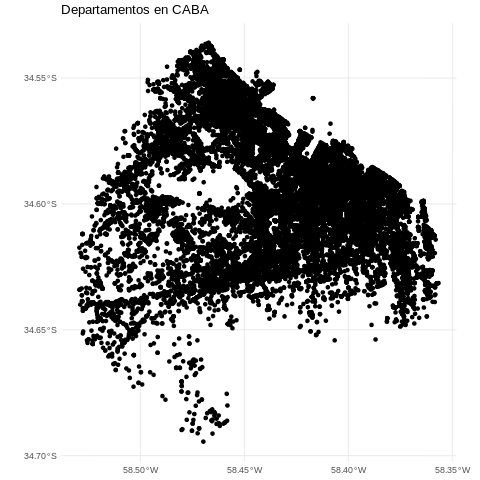

In [5]:
%%R
# Visualizar los datos con ggplot2
ggplot(data = departamentosCABA) +
  geom_sf() +
  theme_minimal() +
  labs(title = "Departamentos en CABA")


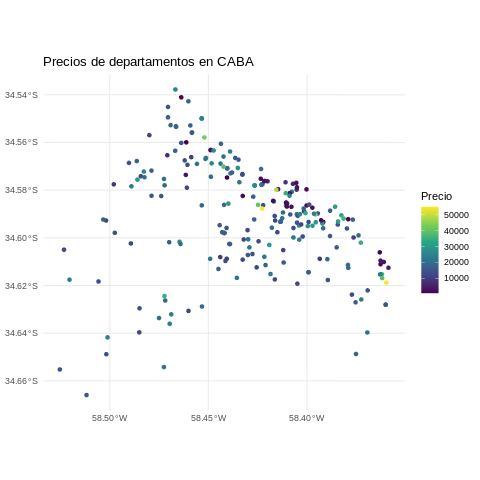

In [6]:
%%R
# Tomar una submuestra y limpiar datos
set.seed(123)  # Para reproducibilidad
departamentosCABA2 <- departamentosCABA[1:500,]
departamentosCABA2 <- departamentosCABA2[departamentosCABA2$price < 80000,]
departamentosCABA2 <- departamentosCABA2[!is.na(departamentosCABA2$price) & !is.na(departamentosCABA2$bedrooms),]

# Visualizar precios
ggplot(data = departamentosCABA2) +
  geom_sf(aes(color = price)) +
  scale_color_viridis_c() +
  theme_minimal() +
  labs(title = "Precios de departamentos en CABA",
       color = "Precio")


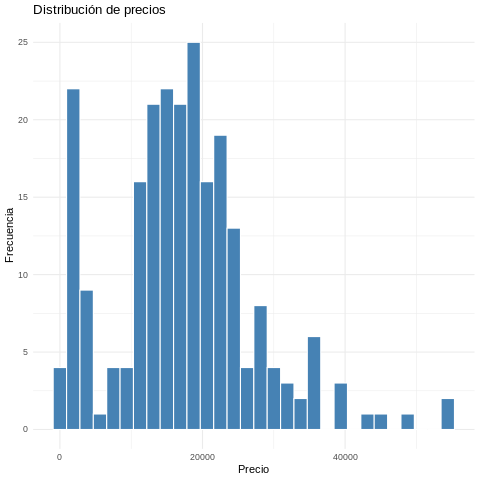

In [7]:
%%R
# Examinar el histograma de precios
ggplot(data = as.data.frame(departamentosCABA2), aes(x = price)) +
  geom_histogram(bins = 30, fill = "steelblue", color = "white") +
  theme_minimal() +
  labs(title = "Distribución de precios",
       x = "Precio",
       y = "Frecuencia")


# Matriz de pesos espaciales

La matriz de pesos es el objeto que nos sirve para especificar las relaciones (espaciales) entre las observaciones. El contenido de la matriz depende de la forma que definamos para medir la dependencia espacial (ver más en los slides de clase).

En este caso, con puntos (resultantes de las coordenadas), vamos a utilizar una medida basada en distancias relativas. En R, usaremos el paquete `spdep` que proporciona funciones para crear y manipular matrices de pesos espaciales.


In addition: Warning message:
In dnearneigh(coords, 0, 1000) : neighbour object has 19 sub-graphs


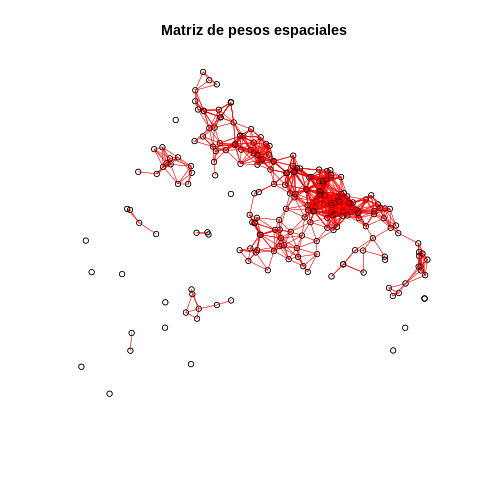

In [9]:
%%R
# Crear matriz de pesos basada en distancia
coords <- st_coordinates(st_centroid(departamentosCABA2))
dists <- dnearneigh(coords, 0, 1000)  # threshold de 1000 metros
wdistance <- nb2listw(dists, style="W", zero.policy = TRUE)

# Visualizar la conectividad
plot(st_geometry(departamentosCABA2), main="Matriz de pesos espaciales")
plot(wdistance, coords, add=TRUE, col='red', lwd=0.5)


# Estadístico de Moran

El estadístico de Moran nos permite medir la autocorrelación espacial en los datos. El scatterplot de Moran muestra la variable $y_i$ (eje x) contra su rezago espacial $y^{lag}_i$ (eje y). El rezago espacial es el promedio entre los vecinos espaciales definidos de acuerdo a nuestra matriz de pesos espaciales ($y^{lag}_{i}=\sum w_iy_i$).

El estadístico de Moran es equivalente al coeficiente de la pendiente lineal de la relación. Su intuición es simple: si hay una relación positiva entre la variable y sus rezagos espaciales es porque hay correlación espacial.



	Moran I test under randomisation

data:  departamentosCABA2$price  
weights: wdistance  
n reduced by no-neighbour observations  

Moran I statistic standard deviate = 0.3457, p-value = 0.3648
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.008294489      -0.004566210       0.001383948 



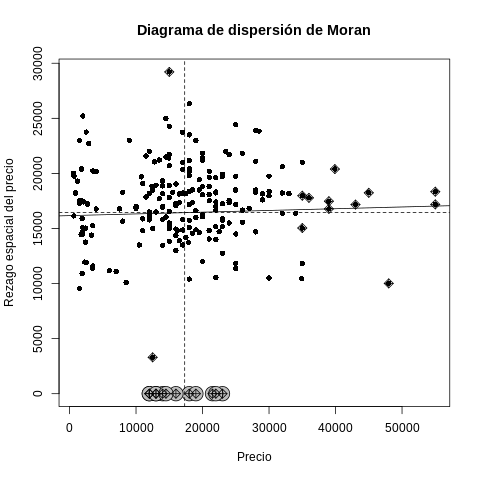

In [10]:
%%R
# Calcular el I de Moran
moran_test <- moran.test(departamentosCABA2$price, wdistance)
print(moran_test)

# Gráfico de Moran
moran.plot(departamentosCABA2$price, wdistance,
           labels=FALSE, pch=16,
           xlab="Precio", ylab="Rezago espacial del precio",
           main="Diagrama de dispersión de Moran")


# Calculamos los pesos espaciales de otra manera

Realizamos un segundo ejemplo, donde vamos a modificar la forma de definir a los vecinos espaciales usando un kernel espacial basado en los k vecinos más cercanos. Este enfoque es similar al kernel gaussiano usado en Python, pero implementado a través de la función `knearneigh` de `spdep`.



	Moran I test under randomisation

data:  departamentosCABA2$price  
weights: kernel_weights    

Moran I statistic standard deviate = -0.6333, p-value = 0.7367
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
    -0.0213780366     -0.0043290043      0.0007247411 



In addition: Warning messages:
1: In knearneigh(coords, k = 10) : knearneigh: identical points found
2: In knearneigh(coords, k = 10) :
  knearneigh: kd_tree not available for identical points


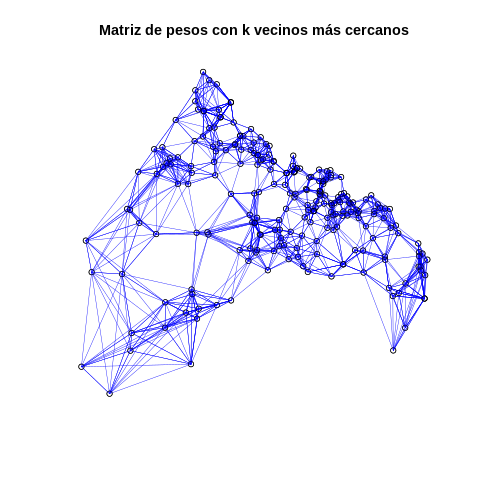

In [11]:
%%R
# Crear matriz de pesos con k vecinos más cercanos
knn <- knearneigh(coords, k=10)
kernel_nb <- knn2nb(knn)
kernel_weights <- nb2listw(kernel_nb, style="W", zero.policy=TRUE)

# Visualizar
plot(st_geometry(departamentosCABA2), main="Matriz de pesos con k vecinos más cercanos")
plot(kernel_weights, coords, add=TRUE, col='blue', lwd=0.5)

# Calcular Moran con nuevos pesos
moran_kernel <- moran.test(departamentosCABA2$price, kernel_weights)
print(moran_kernel)


# Regresión Espacial

Primero corremos una regresión OLS estándar y examinamos la autocorrelación espacial en los residuos. Luego implementaremos un modelo de regresión espacial usando el paquete `spatialreg`.


In [12]:
%%R
# Regresión OLS
ols_model <- lm(price ~ bedrooms, data = departamentosCABA2)
summary(ols_model)

# Test de Moran en los residuos
moran.test(residuals(ols_model), wdistance)



	Moran I test under randomisation

data:  residuals(ols_model)  
weights: wdistance  
n reduced by no-neighbour observations  

Moran I statistic standard deviate = 0.40161, p-value = 0.344
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.010374149      -0.004566210       0.001383949 



Para evitar problemas con el modelo que correremos a continuación, vamos a eliminar del análisis a las observaciones que no tienen vecinos

In [15]:
%%R
# Ver cuántos vecinos tiene cada polígono
n_neighbors <- card(dists)
table(n_neighbors)  # Mira cuántos tienen 0

n_neighbors
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
12  9 10 16  8 11 12 10 16  5 15  8  8 11  9  7  5  9  1  4  1  4  3  4  7  2 
26 27 29 30 31 32 33 35 
 5  3  2  2  3  6  3  1 


In [ ]:
# Filtra los casos sin vecinos
departamentosCABA2_clean <- departamentosCABA2[n_neighbors > 0, ]

# Subset la lista de vecinos también
dists_clean <- subset.nb(dists, n_neighbors > 0)

wdistance_clean <- nb2listw(dists_clean, style="W")




# Regresión con un lag espacial

$y=\rho Wy+\beta X+\epsilon$ \\
donde el primer término representa al rezago espacial. \\
$\rho$ es el coeficiente del rezago \\
W es la matriz de pesos espaciales \\
X es la matriz de variables explicativas exógenas.

En R, usamos la función `lagsarlm` del paquete `spatialreg` para estimar este modelo.


In [17]:
%%R
# Modelo de rezago espacial
spatial_lag <- lagsarlm(price ~ bedrooms, data = departamentosCABA2_clean, listw = wdistance_clean)
summary(spatial_lag)



Call:lagsarlm(formula = price ~ bedrooms, data = departamentosCABA2_clean, 
    listw = wdistance_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-16615.7  -5081.1   -367.0   5161.5  37880.2 

Type: lag 
Coefficients: (numerical Hessian approximate standard errors) 
            Estimate Std. Error z value  Pr(>|z|)
(Intercept) 16185.36    2641.09  6.1283 8.883e-10
bedrooms      351.02     781.63  0.4491    0.6534

Rho: 0.033945, LR test value: 0.067693, p-value: 0.79473
Approximate (numerical Hessian) standard error: 0.12139
    z-value: 0.27965, p-value: 0.77975
Wald statistic: 0.078204, p-value: 0.77975

Log likelihood: -2341.677 for lag model
ML residual variance (sigma squared): 102970000, (sigma: 10147)
Number of observations: 220 
Number of parameters estimated: 4 
AIC: 4691.4, (AIC for lm: 4689.4)



In addition: Warning message:
In lagsarlm(price ~ bedrooms, data = departamentosCABA2_clean, listw = wdistance_clean) :
  inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  reciprocal condition number = 1.44892e-17 - using numerical Hessian.
